# Exploration of Uvira data from January 2025

## Environment Setup

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

## Folder Structure

In [2]:
raw_data_dir = Path("../../data/raw")
img_dir = Path("../../images")

## Data Import

In [3]:
missing_values = ["Missing", "Invalid", "missing age", "Manquant", "Incertaine", "autre", "Uvira_UG_a_incertaine"]

In [4]:
missing_values

['Missing',
 'Invalid',
 'missing age',
 'Manquant',
 'Incertaine',
 'autre',
 'Uvira_UG_a_incertaine']

In [5]:
df_raw = (
    pd.read_csv(
        raw_data_dir / "Histdata_with_results_oxford_23jan2025.csv",
        parse_dates=["dt_case_admission"]
    )
    .rename(
        columns = {
            "id_case": "id",
            "dt_case_admission": "date",
            "cat_case_quarter": "quarter",
            "cat_case_avenue": "avenue",
            "cat_rdt_o1": "rdt_result",
            "cat_culture": "culture_result"
        }
    )
    .replace(missing_values, np.nan)
    .replace(["Hors_Uvira", "hors zone"], "Outside Uvira")
)

In [6]:
df_raw.head()

,id,date,age_group,quarter,avenue,rdt_result,culture_result
0,10070,2016-04-07,15+,nyamianda,av.lumbulumbu.nya,Positive,NaN
1,10071,2016-04-07,<5,rombe2,av.mulongwe.rb2,Negative,NaN
2,10072,2016-04-07,15+,kabindula,av.maombi.kab,Negative,NaN
3,10073,2016-04-07,<5,kalundu,av.bongisa.kal,Negative,NaN
4,10074,2016-04-07,15+,mulongwe,av.shishi.mul,NaN,NaN


## Overview

### Age groups

Text(0, 0.5, 'Count')

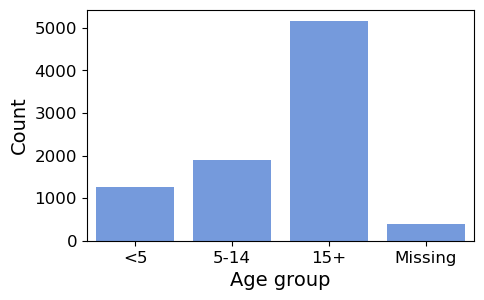

In [7]:
fig, ax = plt.subplots(figsize = (5, 3))
sns.countplot(
    data=df_raw.fillna("Missing"), 
    x="age_group", 
    order = ["<5", "5-14", "15+", "Missing"],
    color="cornflowerblue",
    ax=ax
)
ax.tick_params(labelsize = 12)
ax.set_xlabel("Age group", fontsize = 14)
ax.set_ylabel("Count", fontsize = 14)

### Location Information

Text(0, 0.5, 'Count')

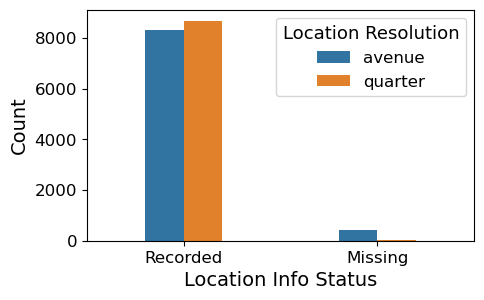

In [8]:
df_to_plot = (
    df_raw
    .fillna("Missing")
        .assign(
            quarter = lambda x: x["quarter"].where(
                x["quarter"] == "Missing",
                "Recorded"
            ),
            avenue = lambda x: x["avenue"].where(
                x["avenue"] == "Missing",
                "Recorded"
            )
        )
    [[
        "id",
        "avenue",
        "quarter",
    ]]
    .melt(
        id_vars = "id",
        value_vars = ["avenue", "quarter"],
        var_name = "location_type",
        value_name = "location"
    )
)

fig, ax = plt.subplots(figsize = (5, 3))
sns.countplot(
    data=df_to_plot,
    x="location", 
    hue="location_type",
    dodge=True,
    width=0.4,
    ax=ax
)
ax.tick_params(labelsize = 12)
ax.legend(title = "Location Resolution", title_fontsize=13, fontsize = 12)
ax.set_xlabel("Location Info Status", fontsize = 14)
ax.set_ylabel("Count", fontsize = 14)

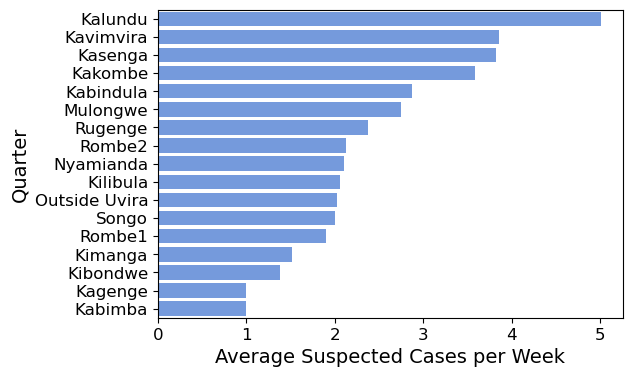

In [9]:
df_to_plot = (
    df_raw
    .assign(
        quarter = lambda x: x["quarter"].str.title()
    )
    .groupby([pd.Grouper(key="date", freq="7D"), "quarter"])
    .agg(
        counts_per_week = ("id", "count")
    )
    .reset_index()
    .groupby("quarter")
    .agg(
        ave_counts_per_week = ("counts_per_week", "mean")
    )
    .sort_values("ave_counts_per_week", ascending = False)
)

fig, ax = plt.subplots(figsize = (6, 4))
sns.barplot(
    df_to_plot["ave_counts_per_week"],
    orient = "h",
    color = "cornflowerblue",
    ax = ax
)
ax.set_xlabel("Average Suspected Cases per Week", fontsize = 14)
ax.set_ylabel("Quarter", fontsize = 14)
ax.tick_params(labelsize = 12)

In [10]:
df_to_plot

,ave_counts_per_week
quarter,
Kalundu,5.008671
Kavimvira,3.852632
Kasenga,3.825581
Kakombe,3.587361
Kabindula,2.875706
Mulongwe,2.753086
Rugenge,2.371069
Rombe2,2.130435
Nyamianda,2.108280


### Test results

Text(0, 0.5, 'Count')

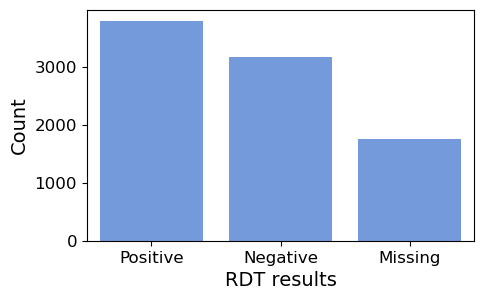

In [11]:
fig, ax = plt.subplots(figsize = (5, 3))
sns.countplot(
    data=df_raw.fillna("Missing"), 
    x="rdt_result", 
    color="cornflowerblue",
    ax=ax
)
ax.tick_params(labelsize = 12)
ax.set_xlabel("RDT results", fontsize = 14)
ax.set_ylabel("Count", fontsize = 14)

In [12]:
(
    df_raw
    .fillna("Missing")
    .groupby(["rdt_result", "culture_result"])
    .agg(
        counts = ("id", "count")
    )
    .reset_index()
    .assign(
        counts_perc = lambda x: x.groupby("rdt_result")["counts"].transform(lambda x: x / x.sum() * 100)
    )
)

,rdt_result,culture_result,counts,counts_perc
0,Missing,Missing,1681,95.783476
1,Missing,Negative,31,1.766382
2,Missing,Positive,43,2.450142
3,Negative,Missing,2213,69.965223
4,Negative,Negative,857,27.094531
5,Negative,Positive,93,2.940247
6,Positive,Missing,1677,44.166447
7,Positive,Negative,460,12.114827
8,Positive,Positive,1660,43.718725


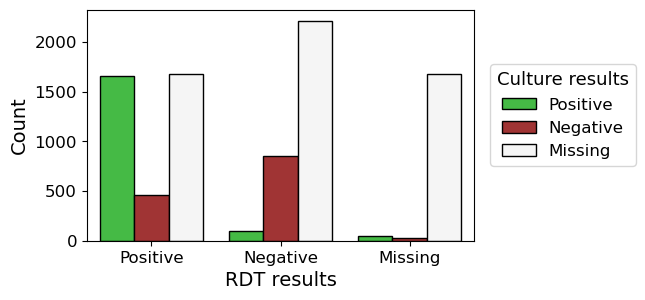

In [14]:
df_to_plot = (
    df_raw
    .fillna("Missing")
    .groupby(["rdt_result", "culture_result"])
    .agg(
        counts = ("id", "count")
    )
    .reset_index()
    .assign(
        counts_perc = lambda x: x.groupby("rdt_result")["counts"].transform(lambda x: x / x.sum() * 100)
    )
)
fig, ax = plt.subplots(figsize = (5, 3))
sns.countplot(
    data=df_raw.fillna("Missing"), 
    x="rdt_result", 
    hue="culture_result",
    hue_order=["Positive", "Negative", "Missing"],
    palette=["limegreen", "firebrick", "whitesmoke"],
    edgecolor="black",
    # stat="percent",
    ax=ax
)
ax.tick_params(labelsize = 12)
ax.set_xlabel("RDT results", fontsize = 14)
ax.set_ylabel("Count", fontsize = 14)
ax.legend(bbox_to_anchor=[1.02, 0.8], title = "Culture results", title_fontsize=13, fontsize = 12)

#### Changes over time

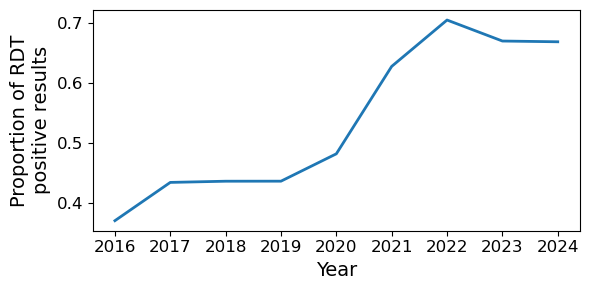

In [11]:
fig, ax = plt.subplots(figsize = (6, 3))
sns.lineplot(
    data=(
        df_raw
        .assign(
            year = lambda x: x["date"].dt.year
        )
        .loc[lambda x: x["year"] < 2025]
        .dropna(subset = ["rdt_result"])
        .groupby("year")
        .agg(
            pos_rate = ("rdt_result", lambda x: x.eq("Positive").mean())
        )
    ),
    # order = ["<5", "5-14", "15+", "Missing"],
    color="cornflowerblue",
    legend=False,
    linewidth=2,
    ax=ax
)
ax.tick_params(labelsize = 12)
ax.set_xlabel("Year", fontsize = 14)
ax.set_ylabel("Proportion of RDT\npositive results", fontsize = 14)
# ax.set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
# ax.set_xticklabels(["2016", "2018", "2020", "2022", "2024"]);
plt.tight_layout()
plt.savefig(img_dir / "rdtpos_vs_time.png", dpi = 300, bbox_inches = "tight")
# ax.set_title("Distribution of RDT results", fontsize = 16)

In [164]:
def test_result_metric(row):
    if (row["rdt_result"] == "Positive") & (row["culture_result"] == "Positive"):
        return "True Positive"
    elif (row["rdt_result"] == "Positive") & (row["culture_result"] == "Negative"):
        return "False Positive"
    elif (row["rdt_result"] == "Negative") & (row["culture_result"] == "Positive"):
        return "False Negative"
    elif (row["rdt_result"] == "Negative") & (row["culture_result"] == "Negative"):
        return "True Negative"

In [165]:
df_test_metrics = (
    df_raw
    .assign(
        year = lambda x: x["date"].dt.year.astype(int),
    )
    .loc[lambda x: (
        (x["year"] < 2025)
        & (x["rdt_result"].notnull())
        & (x["culture_result"].notnull())
    )]
    .assign(
        test_status = lambda x: x.apply(test_result_metric, axis = 1)
    )
    .groupby(["year", "test_status"])
    .agg(
        count = ("id", "count")
    )
    .reset_index()
    .assign(
        tot_tests = lambda x: x.groupby("year")["count"].transform("sum"),
        Proportion = lambda x: x["count"] / x["tot_tests"]
    )
)

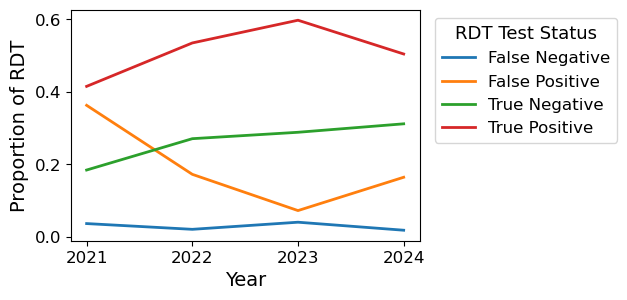

In [171]:
fig, ax = plt.subplots(figsize = (4.5, 3))
sns.lineplot(
    data=df_test_metrics,
    x = "year",
    y = "Proportion",
    hue = "test_status",
    linewidth = 2,
    ax=ax
)
ax.tick_params(labelsize = 12)
ax.set_xlabel("Year", fontsize = 14)
ax.set_ylabel("Proportion of RDT", fontsize = 14)
h, l = ax.get_legend_handles_labels()
ax.legend(
    bbox_to_anchor=[1.02, 1],
    title = "RDT Test Status",
    title_fontsize=13,
    fontsize = 12
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.tight_layout()
plt.savefig(img_dir / "rdtmetrics_vs_time.png", dpi = 300, bbox_inches = "tight")

### Time series

In [9]:
df_hist = (
    df_raw
    .groupby(pd.Grouper(key = "date", freq = "7D"))
    .agg(
        suspected = ("id", "count"),
        confirmed_rdt = ("rdt_result", lambda x: (x == "Positive").sum()),
        confirmed_culture = ("culture_result", lambda x: (x == "Positive").sum())
    )
    .reset_index()
    .melt(
        id_vars = "date",
        value_vars = ["suspected", "confirmed_rdt", "confirmed_culture"],
        var_name = "case_type",
        value_name = "count"
    )
)

In [10]:
df_hist.head()

,date,case_type,count
0,2016-04-07,suspected,65
1,2016-04-14,suspected,82
2,2016-04-21,suspected,27
3,2016-04-28,suspected,14
4,2016-05-05,suspected,10


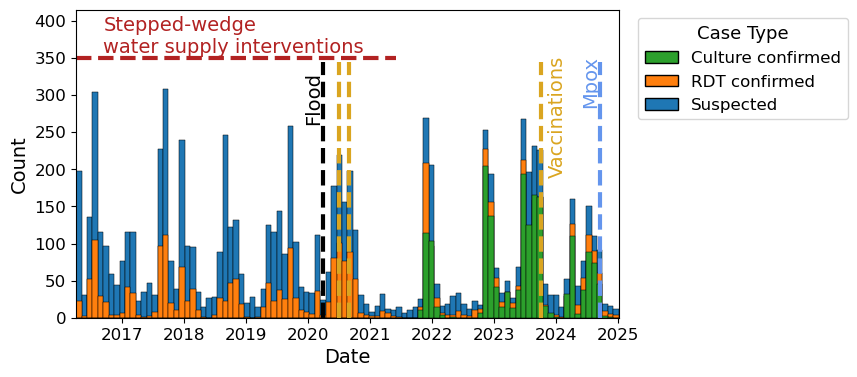

In [25]:
cmap = sns.color_palette("tab10", n_colors=3)[::-1]
fig, ax = plt.subplots(figsize = (7, 4))
sns.histplot(
    data=df_hist, 
    x = "date",
    weights = "count",
    hue = "case_type",
    hue_order = ["confirmed_culture", "confirmed_rdt", "suspected"],
    multiple = "layer",
    palette = cmap,
    alpha = 1,
    bins = 100,
    legend = True,
    ax=ax
)
ax.vlines(
    x = pd.to_datetime("2020-04-01"), 
    ymin = 0,
    ymax = 345,
    linewidth = 3,
    color = "black", 
    linestyle = "--", 
)
ax.text(0.42, 0.8, "Flood", transform=ax.transAxes, fontsize=14, rotation=90, verticalalignment='top')
ax.vlines(
    x = [pd.to_datetime("2020-07-01"), pd.to_datetime("2020-09-01"), pd.to_datetime("2023-10-01")], 
    ymin = 0,
    ymax = 345,
    linewidth = 3,
    color = "goldenrod", 
    linestyle = "--", 
)
ax.text(0.87, 0.85, "Vaccinations", color = "goldenrod", transform=ax.transAxes, fontsize=14, rotation=90, verticalalignment='top')
ax.vlines(
    x = pd.to_datetime("2024-09-15"), 
    ymin = 0,
    ymax = 345,
    linewidth = 3,
    color = "cornflowerblue", 
    linestyle = "--", 
)
ax.text(0.93, 0.85, "Mpox", color = "cornflowerblue", transform=ax.transAxes, fontsize=14, rotation=90, verticalalignment='top')
ax.hlines(
    y = 350, 
    xmin = df_hist["date"].min(),
    xmax = pd.to_datetime("2021-06-01"),
    linewidth = 3,
    color = "firebrick", 
    linestyle = "--", 
)
ax.text(0.05, 0.98, "Stepped-wedge\nwater supply interventions", color = "firebrick", transform=ax.transAxes, fontsize=14, verticalalignment='top')
legend = ax.get_legend()
h = legend.legend_handles
plt.legend(
    handles = h, 
    labels=["Culture confirmed", "RDT confirmed", "Suspected"], 
    title = "Case Type",
    title_fontsize=13,
    fontsize = 12,
    bbox_to_anchor=[1.02, 1]
)
ax.set_ylim(0, 415)
ax.set_xlim(df_hist["date"].min(), df_hist["date"].max())
ax.tick_params(labelsize = 12)
# ax.set_title("Recorded caseload over time", fontsize = 16)
ax.set_xlabel("Date", fontsize = 14)
ax.set_ylabel("Count", fontsize = 14)
# plt.tight_layout()
plt.savefig(img_dir / "hist_vs_time.png", dpi = 300, bbox_inches = "tight")

In [28]:
(
    df_quarter
    .loc[lambda x: x["quarter"] == "kagenge"]
)

,quarter,date,suspected,confirmed_rdt,confirmed_culture
358,kagenge,2019-12-05,1,0,0


In [ ]:
df_hist_quarter = (
    df_raw
    .groupby(["quarter", pd.Grouper(key = "date", freq = "7D")])
    .agg(
        suspected = ("id", "count"),
    )
    .reset_index()
    .loc[lambda x: ~x["quarter"].isin(["kagenge", "kabimba"])]
    .assign(
        quarter = lambda x: x["quarter"].str.title()
    )
)


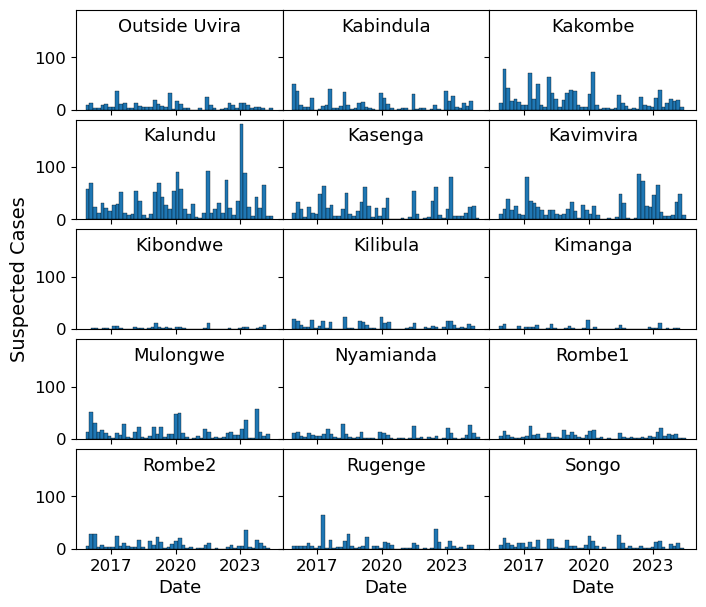

In [174]:
quarters = df_hist_quarter["quarter"].unique()
fig, axes = plt.subplots(
    nrows = 5,
    ncols = 3,
    figsize = (8, 7),
    sharex=True,
    sharey=True
)
axes = axes.flatten()
for i, quarter in enumerate(quarters):
    df_quarter_plot = df_hist_quarter.loc[lambda x: x["quarter"] == quarter]
    (
        sns.histplot(
            data=df_quarter_plot, 
            x = "date",
            weights = "suspected",
            alpha = 1,
            bins = 50,
            legend = False,
            ax=axes[i]
        )
    )
    axes[i].set_title(quarter, fontsize = 13, y = 0.7)
    axes[i].set_xlabel("Date", fontsize = 13)
    axes[i].set_ylabel("")
    axes[i].tick_params(labelsize = 12)
axes[6].set_ylabel("Suspected Cases", fontsize = 14)

for ax in axes[-3:]:
    # ax.set_xlabel("Date", fontsize = 14)
    # ax.set_ylabel("Count", fontsize = 14)
    ax.set(xticks=[pd.Timestamp("2017-06-06"), pd.Timestamp("2020-06-15"), pd.Timestamp("2023-06-15")])
    ax.set_xticklabels(["2017", "2020", "2023"])
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.minorticks_off()
plt.savefig(img_dir / "hist_vs_quarter_time.png", dpi = 300, bbox_inches = "tight")